# Phase III Project Technical Notebook

#### Authors: Kyle Dufrane and Brad Horn

In [1]:
# Import needed libraries

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix

pd.set_option('display.max_columns', 999)

### Business Understanding

#### Flatiron LLC has recently been awarded a contract to maintain wells in Tanzania. They're looking for a system to help develop preventative maintenance schedules by predicting pump failures and replacement schedules to better serve their client.

### Overview

#### Given the business problem we hope to identify the following features through our EDA:
* Are wells failing by geographic location?
* Does well type or source effect pump longevity? 
* Does well management or payment effect pump longevity?

### Data Understanding

#### This dataset comes from the Government of Tanzania and contains over ~59,000 wells with the earliest recorded construction year being 1966. Below you will see our data cleaning process.

#### This dataset comes in three files, test_set, training_set_labels, and training_set_values. We will exclude the test set until the final model has been completed then predict and submit our findings. 

#### To start we will look at the training_set_labels:

In [2]:
# Import training labels CSV
df_training_labels = pd.read_csv('data/Training_set_labels.csv')

In [3]:
df_training_labels.shape

(59400, 2)

In [4]:
df_training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
df_training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


### Checking NA values

In [6]:
df_training_labels.isna().sum()

id              0
status_group    0
dtype: int64

### Class Imbalance

#### Based on our counts, we can see that we will have to counter the class imbalance. We will fix this issue later on in our model building process. 

In [7]:
df_training_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### Training_set_values

In [8]:
# Import training values CSV
df_training_values = pd.read_csv('data/Training_set_values.csv')

In [9]:
df_training_values.shape

(59400, 40)

#### Looking at the above cells output we can see that we have 40 predictive features to chose from being: 

* amount_tsh : Total static head (amount water available to waterpoint)
* date_recorded : The date the row was entered
* funder : Who funded the well
* gps_height : Altitude of the well
* installer : Organization that installed the well
* longitude : GPS coordinate
* latitude : GPS coordinate
* wpt_name : Name of the waterpoint if there is one
* num_private :Private use or not
* basin : Geographic water basin
* subvillage : Geographic location
* region : Geographic location
* region_code : Geographic location (coded)
* district_code : Geographic location (coded)
* lga : Geographic location
* ward : Geographic location
* population : Population around the well
* public_meeting : True/False
* recorded_by : Group entering this row of data
* scheme_management : Who operates the waterpoint
* scheme_name : Who operates the waterpoint
* permit : If the waterpoint is permitted
* construction_year : Year the waterpoint was constructed
* extraction_type : The kind of extraction the waterpoint uses
* extraction_type_group : The kind of extraction the waterpoint uses
* extraction_type_class : The kind of extraction the waterpoint uses
* management : How the waterpoint is managed
* management_group : How the waterpoint is managed
* payment : What the water costs
* payment_type : What the water costs
* water_quality : The quality of the water
* quality_group : The quality of the water
* quantity : The quantity of water
* quantity_group : The quantity of water
* source : The source of the water
* source_type : The source of the water
* source_class : The source of the water
* waterpoint_type : The kind of waterpoint
* waterpoint_type_group : The kind of waterpoint

In [10]:
df_training_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

#### A quick review of the Non-Null column shows that we are missing values in this data set. Below we will dive deeper into which columns are the most effected. 

In [11]:
df_training_values.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

#### Out of the 40 features 7 of them are missing values. A few items stand out:

* Funder and installer have close to equal amounts of missing values
* subvillage has the least amount of missing values
* scheme_name is missing almost half of the values - we will drop this column

In [12]:
# Dropping column from dataframe
df_training_values.drop('scheme_name', axis = 1, inplace = True)

#### We need to explore more to see how we should handle these values.

In [13]:
# creating a list of columns with missing values
missing_values = ['funder', 'installer', 'subvillage', 'public_meeting',\
                  'scheme_management', 'permit']

# creating a dataframe with above missing_values
df_training_values[missing_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   funder             55765 non-null  object
 1   installer          55745 non-null  object
 2   subvillage         59029 non-null  object
 3   public_meeting     56066 non-null  object
 4   scheme_management  55523 non-null  object
 5   permit             56344 non-null  object
dtypes: object(6)
memory usage: 2.7+ MB


In [14]:
df_training_values[missing_values].isna().sum()

funder               3635
installer            3655
subvillage            371
public_meeting       3334
scheme_management    3877
permit               3056
dtype: int64

#### We can now see that all of these features are of the dtype object which narrows down our options to dealing with the missing values. What are these features composed of? 

#### To start, lets take a look at our previous mentioned insite of funders and installers having close to the same amount of missing values. 

##### Note: prior to running the below cells I misread the value counts and thought that both of these columns had the same amount of NA values. The below lines raised the red flag of 'why are the true values the same but the false values differ?'

In [15]:
df_training_values[df_training_values['funder'].isna()]['installer'].isna().value_counts()

True     3582
False      53
Name: installer, dtype: int64

In [16]:
df_training_values[df_training_values['installer'].isna()]['funder'].isna().value_counts()

True     3582
False      73
Name: funder, dtype: int64

#### Looking at the above counts it looks like our counts vary minimally but enough so where we cannot attack these two columns as the same. 

In [17]:
df_training_values['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Isf/gvt                      1
Dokta Mwandulam              1
Act Mara                     1
Fida                         1
Rc/dwe                       1
Name: funder, Length: 1897, dtype: int64

In [18]:
df_training_values[df_training_values['funder'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100,True,GeoData Consultants Ltd,VWC,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,Internal,Mwarufyu,Singida,13,2,Singida Rural,Merya,1,True,GeoData Consultants Ltd,VWC,NaN,1980,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,Internal,Mfumbu,Singida,13,2,Singida Rural,Naintiri,1,True,GeoData Consultants Ltd,VWC,NaN,1970,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
71,17386,0.0,2011-03-31,NaN,0,NaN,34.462228,-8.575780,Kwa Manyusi Mlilo,0,Rufiji,Lembuka,Mbeya,12,7,Mbarali,Mawindi,0,True,GeoData Consultants Ltd,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59357,46563,0.0,2013-02-19,NaN,1635,NaN,34.971841,-5.098362,Shabani,0,Internal,Mampando A,Singida,13,2,Singida Rural,Ntuntu,1,True,GeoData Consultants Ltd,VWC,NaN,1980,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
59366,55232,0.0,2013-02-02,NaN,1541,NaN,34.765729,-5.027725,Joshoni,0,Internal,Mungumaho,Singida,13,2,Singida Rural,Puma,200,True,GeoData Consultants Ltd,VWC,NaN,2000,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
59370,14796,200.0,2013-01-29,NaN,1154,NaN,30.058731,-4.902633,Village Office,0,Lake Tanganyika,Mazungwe,Kigoma,16,2,Kasulu,Rusesa,1,True,GeoData Consultants Ltd,NaN,False,0,other,other,other,unknown,unknown,pay monthly,monthly,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other
59376,34716,0.0,2013-02-03,NaN,1581,NaN,34.821039,-5.076258,Nasingo,0,Internal,Hu,Singida,13,2,Singida Rural,Dung'unyi,1,True,GeoData Consultants Ltd,VWC,NaN,1990,other,other,other,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,other,other


In [19]:
df_training_values['installer'].value_counts()

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Mwamvita Rajabu        1
Mbusi Mwita            1
TASSAF/ TCRS           1
Mwakabalula            1
TSRC                   1
Name: installer, Length: 2145, dtype: int64

In [20]:
df_training_values[df_training_values['installer'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100,True,GeoData Consultants Ltd,VWC,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,Internal,Mwarufyu,Singida,13,2,Singida Rural,Merya,1,True,GeoData Consultants Ltd,VWC,NaN,1980,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,Internal,Mfumbu,Singida,13,2,Singida Rural,Naintiri,1,True,GeoData Consultants Ltd,VWC,NaN,1970,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
71,17386,0.0,2011-03-31,NaN,0,NaN,34.462228,-8.575780,Kwa Manyusi Mlilo,0,Rufiji,Lembuka,Mbeya,12,7,Mbarali,Mawindi,0,True,GeoData Consultants Ltd,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59357,46563,0.0,2013-02-19,NaN,1635,NaN,34.971841,-5.098362,Shabani,0,Internal,Mampando A,Singida,13,2,Singida Rural,Ntuntu,1,True,GeoData Consultants Ltd,VWC,NaN,1980,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
59366,55232,0.0,2013-02-02,NaN,1541,NaN,34.765729,-5.027725,Joshoni,0,Internal,Mungumaho,Singida,13,2,Singida Rural,Puma,200,True,GeoData Consultants Ltd,VWC,NaN,2000,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
59370,14796,200.0,2013-01-29,NaN,1154,NaN,30.058731,-4.902633,Village Office,0,Lake Tanganyika,Mazungwe,Kigoma,16,2,Kasulu,Rusesa,1,True,GeoData Consultants Ltd,NaN,False,0,other,other,other,unknown,unknown,pay monthly,monthly,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other
59376,34716,0.0,2013-02-03,NaN,1581,NaN,34.821039,-5.076258,Nasingo,0,Internal,Hu,Singida,13,2,Singida Rural,Dung'unyi,1,True,GeoData Consultants Ltd,VWC,NaN,1990,other,other,other,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,other,other


In [21]:
df_training_values['subvillage'].value_counts()

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Kisangala        1
Ileza            1
Mwanhembo 1      1
Mwaya B          1
Lojotoo          1
Name: subvillage, Length: 19287, dtype: int64

In [22]:
df_training_values['subvillage'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
59395    False
59396    False
59397    False
59398    False
59399    False
Name: subvillage, Length: 59400, dtype: bool

In [23]:
df_training_values['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [24]:
df_training_values[df_training_values['public_meeting'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466e+00,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
18,34169,0.0,2011-07-22,Hesawa,1162,DWE,32.920154,-1.947868e+00,Ngomee,0,Lake Victoria,Center,Mwanza,19,1,Ukerewe,Ilangala,1000,NaN,GeoData Consultants Ltd,NaN,True,1999,other,other,other,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,spring,spring,groundwater,other,other
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.000000,-2.000000e-08,Muungano,0,Lake Victoria,Ibabachegu,Shinyanga,17,1,Bariadi,Ikungulyabashashi,0,NaN,GeoData Consultants Ltd,WUG,False,0,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump
58,24593,0.0,2013-01-22,Kkkt,1703,KKKT,35.561346,-3.806879e+00,Kwa Iyora Mgirigisi,0,Internal,Ants B,Manyara,21,3,Mbulu,Bargish,456,NaN,GeoData Consultants Ltd,WUG,True,2000,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
73,35715,0.0,2013-02-27,Hesawa,1565,HESAWA,34.657034,-1.888020e+00,Machumbe,0,Lake Victoria,Mtakuja,Mara,20,2,Serengeti,Manchira,200,NaN,GeoData Consultants Ltd,Other,True,1991,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59306,71419,0.0,2013-01-16,Cocern,1296,TWESA,30.930385,-3.300592e+00,Kwa Mhunda,0,Lake Tanganyika,Nguvu Kazi A,Kigoma,16,1,Kibondo,Kakonko,1,NaN,GeoData Consultants Ltd,NaN,False,2013,gravity,gravity,gravity,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,spring,spring,groundwater,improved spring,improved spring
59310,32815,0.0,2013-04-04,Tasaf,892,TASAF,37.744090,-4.062296e+00,Ward Office,0,Pangani,Same,Kilimanjaro,3,3,Same,Same Urban,65,NaN,GeoData Consultants Ltd,NaN,NaN,0,other,other,other,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.000000,-2.000000e-08,Mwazwilo,0,Lake Victoria,Mbita,Shinyanga,17,1,Bariadi,Mbita,0,NaN,GeoData Consultants Ltd,WUG,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
59344,6450,0.0,2013-10-03,NaN,1303,NaN,36.900911,-3.111477e+00,Pentecoste Swidish,0,Internal,Madukani,Arusha,2,7,Meru,Ngarenanyuki,230,NaN,GeoData Consultants Ltd,NaN,NaN,0,gravity,gravity,gravity,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,spring,spring,groundwater,communal standpipe,communal standpipe


In [25]:
df_training_values[df_training_values['public_meeting'].isna()]['recorded_by'].value_counts()

GeoData Consultants Ltd    3334
Name: recorded_by, dtype: int64

#### Inspecting the above dataframe you can see that all the items have been recorded by GeoData Consultants Ltd. Lets take a look at the whole dataframe. 

In [26]:
df_training_values[df_training_values['recorded_by'] == 'GeoData Consultants Ltd']['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

#### Seeing how all of the data has been recorded by the same vendor this will have no impact on our modeling. This is another column that we can drop. 

In [27]:
df_training_values.drop('recorded_by', axis = 1, inplace = True)

In [28]:
df_training_values['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [29]:
df_training_values['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

## Data Preparation

### For each column we will create two variables for modeling. One with the mode value for each column and one with a newly created variable denoted 'other'.

In [30]:
# Creating new dataframe
df_training_val_mode = df_training_values.copy()
df_training_val_other = df_training_values.copy()


In [31]:
# Filling NAN values to 'Other'

df_training_val_other['funder'] = df_training_val_other['funder']\
                            .replace(np.nan, 'Other', regex = True)

df_training_val_other['installer'] = df_training_val_other['installer']\
                                .replace(np.nan, 'Other', regex = True)

df_training_val_other['subvillage'] = df_training_val_other['subvillage']\
                                    .replace(np.nan, 'Other', regex = True)

df_training_val_other['public_meeting'] = df_training_val_other['public_meeting']\
                                            .replace(np.nan, 'Other', regex = True)

df_training_val_other['scheme_management'] = df_training_val_other['scheme_management']\
                                                .replace(np.nan, 'Other', regex = True)

df_training_val_other['permit'] = df_training_val_other['permit']\
                            .replace(np.nan, 'Other', regex = True)


In [32]:
# Filling NAN values with most common feature based on count

df_training_val_mode['funder'].fillna(df_training_val_mode['funder']\
                        .value_counts().index[0], inplace = True)

df_training_val_mode['installer'].fillna(df_training_val_mode['installer']\
                                .value_counts().index[0], inplace = True)

df_training_val_mode['subvillage'].fillna(df_training_val_mode['subvillage']\
                                    .value_counts().index[0], inplace = True)

df_training_val_mode['public_meeting'].fillna(df_training_val_mode['public_meeting']\
                                            .value_counts().index[0], inplace = True)

df_training_val_mode['scheme_management'].fillna(df_training_val_mode['scheme_management']\
                                                 .value_counts().index[0], inplace = True)

df_training_val_mode['permit'].fillna(df_training_val_mode['permit']\
                            .value_counts().index[0], inplace = True)

In [33]:
df_training_val_mode.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

In [34]:
df_training_val_other.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

### Joining Tables

#### Now lets merge the tables so we only have two data sets to work with. To start, both dataframes have an ID column so we will create a new column on our target set and drop the identical column.

In [35]:
df_training_labels['id_2'] = df_training_labels['id']
df_training_labels.drop('id', axis = 1, inplace = True)

#### Next we will join our tables and create two dataframes for mode and other

In [36]:
df_mode = pd.concat([df_training_val_mode, df_training_labels], join = 'inner', axis = 1)
df_other = pd.concat([df_training_val_other, df_training_labels], join = 'inner', axis = 1)

In [37]:
df_mode

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,id_2
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,69572
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,8776
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,34310
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,67743
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,VWC,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,19728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,Water Board,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,60739
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,VWC,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,27263
59397,37057,0.0,2011-04-11,Government Of Tanzania,0,DWE,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,37057
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,31282


In [38]:
df_mode[df_mode['id'] == df_mode['id_2']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,id_2
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,69572
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,8776
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,34310
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,67743
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,VWC,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,19728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,Water Board,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,60739
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,VWC,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,27263
59397,37057,0.0,2011-04-11,Government Of Tanzania,0,DWE,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,37057
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,31282


In [39]:
df_other[df_other['id'] == df_other['id_2']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,id_2
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,69572
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,Other,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,8776
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,34310
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,67743
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,Other,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,19728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,Water Board,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,60739
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,VWC,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,27263
59397,37057,0.0,2011-04-11,Other,0,Other,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,37057
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,31282


#### As seen above our total rows equal that of the normal dataframe so we can conclude that our merges have been successful and we can drop our id_2 column.

In [40]:
df_mode.drop(['id_2'], axis = 1, inplace = True)
df_other.drop(['id_2'], axis = 1, inplace = True)

### Additional Columns to Drop

#### The Id columns and date_recorded are considered admin columns and will not have much predictive power in our model therefore we can drop these columns. 

In [41]:
df_mode.drop(['id', 'date_recorded'], axis = 1, inplace = True)
df_other.drop(['id', 'date_recorded'], axis = 1, inplace = True)

In [42]:
def get_totals(dataframe, filter_column, filter_groupby):

        '''
        **** filter_column & filter_groupby need to be passed
        as strings ****

        1. get_totals will calculate the sum of the variables
        within a column and return a new column with the 
        sum of their total occurances in the dataframe
        
        2. get_totals will calulate the percentage of the 
        values column vs the total values

        dataframe = pandas dataframe
        filter_column = column to filter by
        filter_groupby = groupby column to filter by

        '''

        df_new = pd.DataFrame(dataframe.groupby(filter_groupby)[filter_column].value_counts())
        df_new[f'{filter_groupby}_values'] = df_new[filter_column]
        df_new.drop(filter_column, axis = 1, inplace = True)
        df_new.reset_index(inplace = True)

        types = set()

        for idx, value in enumerate(df_new[f'{filter_groupby}_values']):
            for type_ in df_new[filter_column]:
                types.add(type_)
            
        total_values = {}
            
        for value in types:
            total_values[value] = df_new[df_new[filter_column] == value][f'{filter_groupby}_values'].sum()

        df_new[f'{filter_groupby}_total_values'] = df_new[filter_column].map(total_values)

        df_new[f'{filter_groupby}_percentage'] = df_new[f'{filter_groupby}_values'] / df_new[f'{filter_groupby}_total_values']
            
        return df_new


In [43]:
# function_df = df.drop('status_group', axis = 1)

# percentage_dict = {}

# for idx, column in enumerate(function_df.columns):
#     percentage_dict[column] = get_totals(df, column, 'status_group')

# pickle_out = open('percentage_dict.pickle', 'wb')
# pickle.dump(percentage_dict, pickle_out)

In [44]:
pickle_in = open('percentage_dict.pickle', 'rb')

percentage_dict = pickle.load(pickle_in)

### First Simple Model

In [45]:
df_mode.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

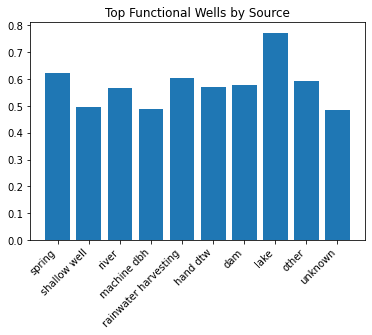

In [46]:
source = percentage_dict['source']
functional = source[source['status_group'] == 'functional']
functional

plt.bar(source['source'], source['status_group_percentage'])
plt.xticks(rotation=45, ha='right')
plt.title('Top Functional Wells by Source')
plt.savefig('saved_objects/source_bar');

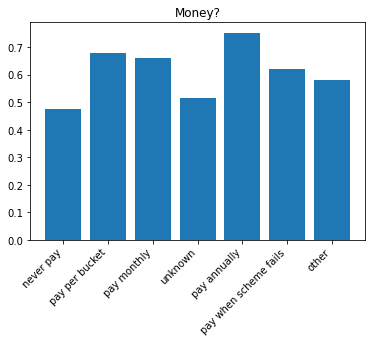

In [143]:
source = percentage_dict['payment']
functional = source[source['status_group'] == 'functional']
functional

plt.bar(source['payment'], source['status_group_percentage'])
plt.xticks(rotation=45, ha='right')
plt.title('Money?')
plt.savefig('saved_objects/money_bar');

#### To start our modeling process we will use only our integers and floats.

In [48]:
X_mode_fsm = df_mode.select_dtypes(['int64', 'float64'])
y_mode_fsm = df_mode['status_group']

X_other_fsm = df_other.select_dtypes(['int64','float64'])
y_other_fsm = df_other['status_group']

In [49]:
X_mode_train, X_mode_test, y_mode_train, y__mode_test = train_test_split(X_mode_fsm,y_mode_fsm, random_state = 42, stratify = y_mode_fsm)

X_other_train, X_other_test, y_other_train, y_other_test = train_test_split(X_other_fsm,y_other_fsm, random_state = 42, stratify = y_mode_fsm)


dtc_mode = DecisionTreeClassifier()
dtc_other = DecisionTreeClassifier()

dtc_mode.fit(X_mode_train, y_mode_train)
dtc_other.fit(X_other_train, y_other_train)

DecisionTreeClassifier()

In [50]:
print(dtc_mode.score(X_mode_train, y_mode_train))
print(dtc_other.score(X_other_train, y_other_train))

0.9858810325476992
0.9858810325476992


In [51]:
y_hat_mode = dtc_mode.predict(X_mode_train)
y_hat_other = dtc_other.predict(X_other_train)

In [52]:
print('mode recall:', recall_score(y_mode_train, y_hat_mode, average = 'macro'))
print('mode precision:', precision_score(y_mode_train, y_hat_mode, average = 'macro'))
print('mode f1 score:', f1_score(y_mode_train, y_hat_mode, average = 'macro'))

print('---------------------------------------------------------')

print('ohter recall:', recall_score(y_other_train, y_hat_other, average = 'macro'))
print('other precision:', precision_score(y_other_train, y_hat_other, average = 'macro'))
print('other f1 score:', f1_score(y_other_train, y_hat_other, average = 'macro'))

mode recall: 0.9646151149443224
mode precision: 0.9910484321431677
mode f1 score: 0.9771278730975221
---------------------------------------------------------
ohter recall: 0.9646151149443224
other precision: 0.9910484321431677
other f1 score: 0.9771278730975221


In [53]:
cross_val_score(dtc_mode, X_mode_train, y_mode_train, cv = 3, scoring = 'recall_macro')

array([0.53856041, 0.54222166, 0.54461778])

In [54]:
cross_val_score(dtc_other, X_mode_train, y_mode_train, cv = 3, scoring = 'recall_macro')

array([0.54096196, 0.54618932, 0.54473954])

### The cross val scores are pretty consitent across the folds. This doesnt give us much insight as far as our NAN replacements in during the EDA. 

### Model Exploration

#### Now that we have our baseline established we will loop through other models to see if we can get better results.

In [55]:
# model_selection = [LogisticRegression(random_state = 42, max_iter = 1000, n_jobs = -1),\
#                    RandomForestClassifier(random_state = 42, n_jobs = -1),\
#                    DecisionTreeClassifier(), KNeighborsClassifier(n_jobs = -1), 
#                   SVC(random_state = 42)]

# vanilla_models = {}

# for idx_mode, model in enumerate(model_selection):
#     vanilla_models[idx_mode] = model.fit(X_mode_train, y_mode_train)

In [56]:
# for key, val in enumerate(vanilla_models.values()):
#     print(val, val.score(X_mode_train, y_mode_train))

#### Based on the scores above, our scores are the best using RandomForestClassifier and DecisionTreeClassifier. Let's did deeper into these two models.

In [57]:
# # Select models from dictionary
# rfc = vanilla_models[1]
# dtc = vanilla_models[2]

# # predict on each model

# rfc_mode_yhat = rfc.predict(X_mode_train)
# dtc_mode_yhat = dtc.predict(X_mode_train)

In [58]:
# # Review scores for both models

# print('rfc recall:', recall_score(y_mode_train, rfc_mode_yhat, average = 'macro'))
# print('rfc precision:', precision_score(y_mode_train, rfc_mode_yhat, average = 'macro'))
# print('rfc f1 score:', f1_score(y_mode_train, rfc_mode_yhat, average = 'macro'))

# print('---------------------------------------------------------')

# print('dtc recall:', recall_score(y_mode_train, dtc_mode_yhat, average = 'macro'))
# print('dtc precision:', precision_score(y_mode_train, dtc_mode_yhat, average = 'macro'))
# print('dtc f1 score:', f1_score(y_mode_train, dtc_mode_yhat, average = 'macro'))


### Small advantage do the decision tree classifier. Lets see if our cross val & auc score shows anymore insights. 

In [59]:
# cross_val_score(rfc, X_mode_train, y_mode_train, cv = 5, n_jobs=-1, scoring = 'recall_macro')

In [60]:
# cross_val_score(dtc, X_mode_train, y_mode_train, cv = 5, n_jobs = -1, scoring = 'recall_macro')

### Since our stakeholder is considered with pump failures we need to avoid False Negatives. I.E. we do not want to say the bump is broken when it in fact it is operational. Therefore we need to focus on our recall score and tune our model appropriately which is why we're using the recall_macro score. As seen above our Random Forest is performing the best. We will move forward with tuning this model going forward.

### Our models above only utilized our numerical values. We will now begin using our categorical features and identify feature importance. 

In [61]:
# # Separate data by target and predictors
# X_cat = df_mode.drop('status_group', axis = 1)
# y_cat = df_mode['status_group']

# # Perform train test split
# X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, random_state = 42, stratify = y_cat)

# # One hot encoded categorical data
# ohe = OneHotEncoder(drop = 'first')


# # Select initial parameters
# df_feat_import = X_train_cat[['extraction_type', 'management', 'payment', 'water_quality', 'source', 'source_class', 'region_code', 'district_code']]

# # fit transform data
# X_mode_train_enc = ohe.fit_transform(df_feat_import)

# # Instantiate model
# rfc_feat_import = RandomForestClassifier(random_state = 42, class_weight= 'balanced', n_jobs = -1)


# # Fit encoded data to model
# rfc_feat_import.fit(X_mode_train_enc, y_train_cat)

# # Model score
# rfc_feat_import.score(X_mode_train_enc, y_train_cat)

# # Predict on training data
# rfc_yhat_1 = rfc_feat_import.predict(X_mode_train_enc)

# # Recall score on training data
# recall_score(y_train_cat, rfc_yhat, average='macro')

# # Precision score on training data
# precision_score(y_train_cat, rfc_yhat, average='macro')

# #F1 Score on training data
# f1_score(y_train_cat, rfc_yhat, average='macro')

# # 5-fold cross validation
# cross_val_score(rfc_feat_import, X_mode_train_enc, y_train_cat, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_mode_train_enc, y_train_cat);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# #### Adding features to see if our model improves all other steps are a repeat from above

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_cat[[
#  'source_type',
#  'region',
#  'district_code',
#  'public_meeting',
#  'extraction_type',
#  'extraction_type_group',
#  'extraction_type_class',
#  'management',
#  'payment_type',
#  'quantity_group',
#  'source',
#  'source_class',
#  'waterpoint_type_group']]

# X_mode_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(random_state = 42, class_weight= 'balanced', n_jobs = -1)

# rfc_feat_import.fit(X_mode_train_enc, y_train_cat)

# rfc_feat_import.score(X_mode_train_enc, y_train_cat)

# rfc_yhat = rfc_feat_import.predict(X_mode_train_enc)

# recall_score(y_train_cat, rfc_yhat, average = 'macro')

# cross_val_score(rfc_feat_import, X_mode_train_enc, y_train_cat, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_mode_train_enc, y_train_cat);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# #### Adding features to see if our model improves all other steps are a repeat from above

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_cat[['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
#                    'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',\
#                   'extraction_type_group', 'extraction_type_class','management',\
#                    'management_group', 'payment', 'payment_type', 'water_quality',\
#                   'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
#                    'source_class', 'waterpoint_type', 'waterpoint_type_group']]

# X_mode_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(random_state = 42)

# rfc_feat_import.fit(X_mode_train_enc, y_train_cat)

# rfc_feat_import.score(X_mode_train_enc, y_train_cat)

# rfc_yhat = rfc_feat_import.predict(X_mode_train_enc)

# recall_score(y_train_cat, rfc_yhat, average = 'macro')

# cross_val_score(rfc_feat_import, X_mode_train_enc, y_train_cat, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_mode_train_enc, y_train_cat);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# ### Now that we have seen model improvement we will use a GridSearch to find our best parameters

# # param_grid = {
# #  'max_depth': [3,10, None],
# #  'criterion': ['gini', 'entropy'],
# #  'min_samples_leaf': [1, 2, 4],
# #  'n_estimators': [100, 500],
# #  'class_weight': ['balanced', 'balanced_subsample'],
# #  'n_jobs': [-1]
# # }

# # grid_search = GridSearchCV(rfc_feat_import, param_grid, n_jobs=-1, cv = 3, return_train_score=True)

# # grid_search.fit(X_mode_train_enc, y_train_cat)

# # 'grid_search.best_params_'

# # "'class_weight': 'balanced',
# #  'criterion': 'entropy',
# #  'max_depth': None,
# #  'min_samples_leaf': 1,
# #  'n_estimators': 500,
# #  'n_jobs': -1")

# #### Base on our best_params_ we will input these features into a new to model and repeat the above steps

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_cat[['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
#                    'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',\
#                   'extraction_type_group', 'extraction_type_class','management',\
#                    'management_group', 'payment', 'payment_type', 'water_quality',\
#                   'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
#                    'source_class', 'waterpoint_type', 'waterpoint_type_group']]

# X_mode_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(random_state = 42, class_weight='balanced', criterion='entropy', n_estimators = 500, n_jobs=-1)

# rfc_feat_import.fit(X_mode_train_enc, y_train_cat)

# rfc_feat_import.score(X_mode_train_enc, y_train_cat)

# rfc_yhat = rfc_feat_import.predict(X_mode_train_enc)

# recall_score(y_train_cat, rfc_yhat, average = 'macro')

# cross_val_score(rfc_feat_import, X_mode_train_enc, y_train_cat, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_mode_train_enc, y_train_cat);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# ### Based on our previous model our recall jumped to 85.86% from 77.56%! Also, our cross_val_score is within < 2% span which is showing that our model has low bias. 

# ### Previously we separated our data into two data frames. We will repeat the above process with the second dataframe to see if we get different results.

# X_other = df_other.drop('status_group', axis = 1)
# y_other = df_other['status_group']

# X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(X_other, y_other, random_state = 42, stratify = y_other)

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_other[['extraction_type', 'management', 'payment', 'water_quality', 'source', 'source_class', 'region_code', 'district_code']]

# X_other_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(random_state = 42, class_weight= 'balanced', n_jobs = -1)

# rfc_feat_import.fit(X_other_train_enc, y_train_other)

# rfc_feat_import.score(X_other_train_enc, y_train_other)

# rfc_yhat = rfc_feat_import.predict(X_other_train_enc)

# recall_score(y_train_other, rfc_yhat, average='macro')

# cross_val_score(rfc_feat_import, X_other_train_enc, y_train_other, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_other_train_enc, y_train_other);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_other[[
#  'source_type',
#  'region',
#  'district_code',
#  'extraction_type',
#  'extraction_type_group',
#  'extraction_type_class',
#  'management',
#  'payment_type',
#  'quantity_group',
#  'source',
#  'source_class',
#  'waterpoint_type_group']]

# X_other_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(random_state = 42, class_weight= 'balanced', n_jobs = -1)

# rfc_feat_import.fit(X_other_train_enc, y_train_other)

# rfc_feat_import.score(X_other_train_enc, y_train_other)

# rfc_yhat = rfc_feat_import.predict(X_other_train_enc)

# recall_score(y_train_other, rfc_yhat, average='macro')

# cross_val_score(rfc_feat_import, X_other_train_enc, y_train_other, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_other_train_enc, y_train_other);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_other[['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
#                     'scheme_management', 'construction_year', 'extraction_type',\
#                   'extraction_type_group', 'extraction_type_class','management',\
#                    'management_group', 'payment', 'payment_type', 'water_quality',\
#                   'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
#                    'source_class', 'waterpoint_type', 'waterpoint_type_group']]

# X_other_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(random_state = 42)

# rfc_feat_import.fit(X_other_train_enc, y_train_other)

# rfc_feat_import.score(X_other_train_enc, y_train_other)

# rfc_yhat = rfc_feat_import.predict(X_other_train_enc)

# recall_score(y_train_other, rfc_yhat, average='macro')

# cross_val_score(rfc_feat_import, X_other_train_enc, y_train_other, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_other_train_enc, y_train_other);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

# param_grid = {
#  'max_depth': [3,10, None],
#  'criterion': ['gini', 'entropy'],
#  'min_samples_leaf': [1, 2, 4],
#  'n_estimators': [100, 500],
#  'class_weight': ['balanced', 'balanced_subsample'],
#  'n_jobs': [-1]
# }

# grid_search = GridSearchCV(rfc_feat_import, param_grid, n_jobs=-1, cv = 3, return_train_score=True)

# grid_search.fit(X_other_train_enc, y_train_other)

# grid_search.best_params_

# grid_search.best_score_

# ohe = OneHotEncoder(drop = 'first')

# df_feat_import = X_train_other[['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
#                     'scheme_management', 'construction_year', 'extraction_type',\
#                   'extraction_type_group', 'extraction_type_class','management',\
#                    'management_group', 'payment', 'payment_type', 'water_quality',\
#                   'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
#                    'source_class', 'waterpoint_type', 'waterpoint_type_group']]

# X_other_train_enc = ohe.fit_transform(df_feat_import)

# rfc_feat_import = RandomForestClassifier(class_weight='balanced_subsample', criterion='gini', min_samples_leaf=1, n_estimators=100, random_state = 42, n_jobs=-1)

# rfc_feat_import.fit(X_other_train_enc, y_train_other)

# rfc_feat_import.score(X_other_train_enc, y_train_other)

# rfc_yhat = rfc_feat_import.predict(X_other_train_enc)

# recall_score(y_train_other, rfc_yhat, average='macro')

# cross_val_score(rfc_feat_import, X_other_train_enc, y_train_other, cv = 5, scoring = 'recall_macro')

# plot_confusion_matrix(rfc_feat_import, X_other_train_enc, y_train_other);

# visualizer = ROCAUC(clf)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_train, y_train)
# visualizer.show()

### This model performed almost as good as the first one. With the first model getting a recall score of 85.86% it has beaten the second model by .58%, not much but still an increase that we're looking for!

### Categorical & Numerical Data

### Finally we will build a pipeline to incorporate all of our data.

In [62]:
X = df_mode[['region_code', 'source_type', 'basin', 'region', 'district_code',\
                   'public_meeting', 'scheme_management', 'permit', 'extraction_type',\
                  'extraction_type_group', 'extraction_type_class','management',\
                   'management_group', 'payment', 'payment_type', 'water_quality',\
                  'quality_group', 'quantity', 'quantity_group', 'source',
                   'source_class', 'waterpoint_type', 'waterpoint_type_group', 'gps_height', 'population',\
                   'construction_year', 'num_private', 'longitude', 'latitude']]

y = df_mode['status_group']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [63]:
cat_features = ['region_code', 'source_type', 'basin', 'region', 'district_code', 'public_meeting', 
                'scheme_management', 'permit', 'construction_year', 'extraction_type', 
                'extraction_type_group', 'extraction_type_class','management', 'management_group', 
                'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 
                'quantity_group', 'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

num_features = ['gps_height', 'population', 'construction_year', 'num_private', 'longitude', 'latitude']

categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

numerical_transformer = SimpleImputer()

preprocessor = ColumnTransformer([('cat', categorical_transformer, cat_features), 
                                  ('num', numerical_transformer, num_features)])


clf = Pipeline([('preprocessor', preprocessor), 
               ('classifier', RandomForestClassifier(verbose = 1, random_state = 42))])

clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region_code', 'source_type',
                                                   'basin', 'region',
                                                   'district_code',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit',
                                                   'construction_year',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                        

In [64]:
clf.score(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


0.9951964085297419

In [65]:
y_hat = clf.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [66]:
recall_score(y_train, y_hat, average = 'macro')

0.9886982456927843

In [67]:
param_grid = {
 'classifier__max_depth': [3,10, None],
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__min_samples_leaf': [1, 2, 4],
 'classifier__n_estimators': [100, 500],
 'classifier__class_weight': ['balanced', 'balanced_subsample'],
 'classifier__n_jobs': [-1]
}

grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv = 3, return_train_score=True)

grid_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['region_code',
                                                                          'source_type',
                                                                          'basin',
                                                                          'region',
                                                                          'district_code',
                                                                          'public_meeting',
                                                                          'scheme_management',
                                                                          'permit',
                         

In [111]:
feat_import_nam = list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features = cat_features))
feat_import_nam = feat_import_name + num_features
feat_import_num = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feat_import = pd.DataFrame(feat_import_num, index=feat_import_name)

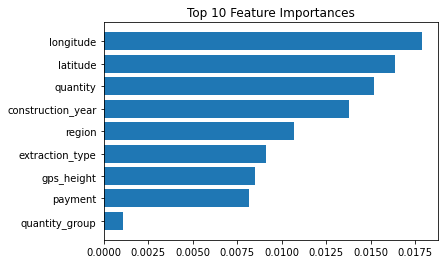

In [144]:
feat_import_name = []
feat_import_value = []

for name in cat_features+num_features:
    total = 0
    avg = 0
    for i in range(len(feat_import_num)):
        if name in feat_import_nam[i]:
            avg += 1
            total += feat_import_num[i]
            
    feat_import_name.append(name)
    feat_import_value.append(total)
    
feat_import = pd.DataFrame(feat_import_value, index=feat_import_name)
feat_import.sort_values(0, inplace=True)



plt.barh(list(feat_import.index[-10:]), feat_import[0].head(10).values, )
plt.xticks()
plt.title('Top 10 Feature Importances')
plt.savefig('saved_objects/feat_import');

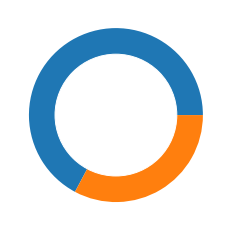

In [146]:
# create data
size_of_groups=[67.2,100-67.2]

# Create a pieplot
plt.pie(size_of_groups)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

In [82]:
grid_search.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 500,
 'classifier__n_jobs': -1}

In [84]:
grid_search.best_score_

0.7893602693602694

In [85]:
yhat = grid_search.predict(X_train)

print('recall score:', recall_score(y_train, yhat, average = 'macro'))
print('precision score:', precision_score(y_train, yhat, average = 'macro'))
print('f1 score:', f1_score(y_train, yhat, average = 'macro'))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.1s finished


recall score: 0.9949790692627062
precision score: 0.9789826140011134
f1 score: 0.9867055064812975


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.1s finished


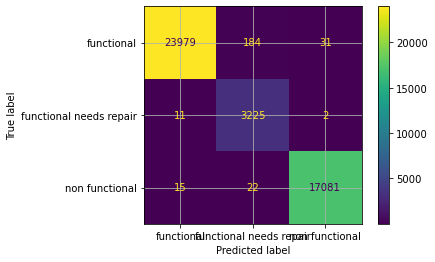

In [86]:
plot_confusion_matrix(grid_search, X_train, y_train)
plt.grid(None);

In [87]:
visualizer = ROCAUC(clf)
visualizer.fit(X_train, y_train)
visualizer.score(X_train, y_train)
visualizer.show()


NameError: name 'ROCAUC' is not defined

In [88]:
y_hat_test = grid_search.predict(X_test)

print('recall score:', recall_score(y_test, y_hat_test, average = 'macro'))
print('precision score:', precision_score(y_test, y_hat_test, average = 'macro'))
print('f1 score:', f1_score(y_test, y_hat_test, average = 'macro'))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished


recall score: 0.6814602371397417
precision score: 0.7212935560543485
f1 score: 0.6975330558413705


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished


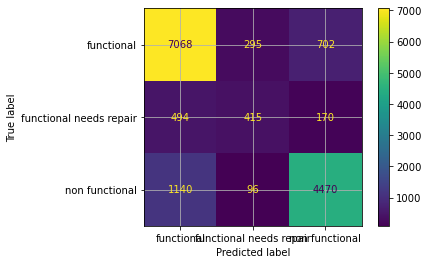

In [89]:
plot_confusion_matrix(grid_search, X_test, y_test)
plt.grid(None)
plt.savefig('saved_objects/final_confusion');

In [90]:
visualizer = ROCAUC(clf)
visualizer.fit(X_test, y_test)
visualizer.score(X_test, y_test)
visualizer.show()
plt.savefig('saved_objects/final_ROC_AUC')

NameError: name 'ROCAUC' is not defined

In [91]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(features.columns))
X_poly_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names(features.columns))
X_poly_train.head()

ValueError: could not convert string to float: 'spring'

In [92]:
from sklearn.feature_selection import VarianceThreshold

threshold_ranges = np.linspace(0, 2, num=6)

for thresh in threshold_ranges:
    print(thresh)
    selector = VarianceThreshold(thresh)
    reduced_feature_train = selector.fit_transform(X_train)
    reduced_feature_test = selector.transform(X_test)
    lr = RandomForestClassifier()
    lr.fit(reduced_feature_train, y_train)
    run_model(lr, reduced_feature_train, reduced_feature_test, y_train, y_test)
    print('--------------------------------------------------------------------')

0.0


ValueError: could not convert string to float: 'spring'